In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [29]:
data_dir = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print(f"Classes found: {class_names}")
print(f"Total images: {len(dataset)}")

Classes found: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Total images: 1125


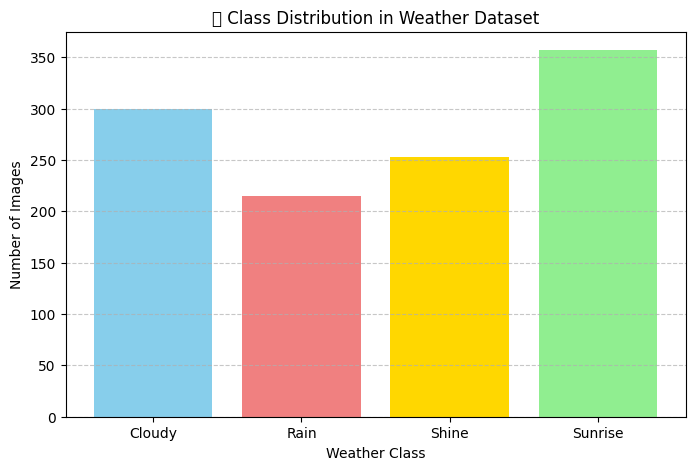

In [31]:

# --- 4️⃣ Class Distribution Visualization ---
class_counts = {cls: 0 for cls in class_names}
for _, label in dataset.samples:
    class_counts[class_names[label]] += 1

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'lightcoral', 'gold', 'lightgreen'])
plt.title('📊 Class Distribution in Weather Dataset')
plt.xlabel('Weather Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_133/2445484202.py:18: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  plt.tight_layout()


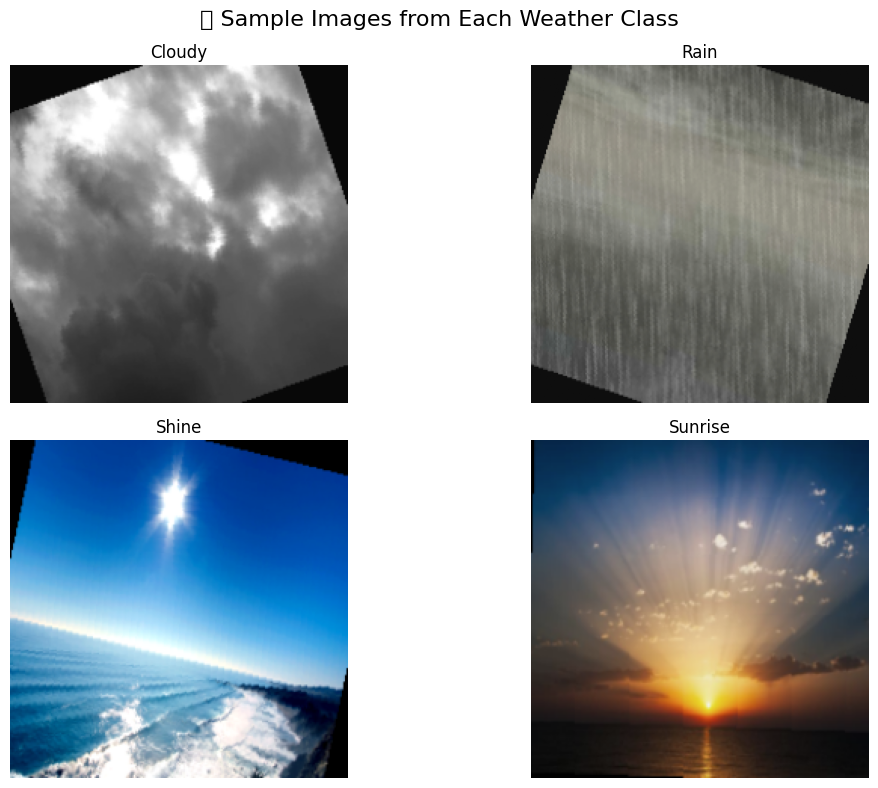

In [32]:
import numpy as np
# --- 5️⃣ Visualize Random Samples from Each Class ---
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(np.clip(img, 0, 1))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 8))
for i, cls in enumerate(class_names):
    # get one sample from each class
    idx = [j for j, (_, label) in enumerate(dataset.samples) if label == i][0]
    image, _ = dataset[idx]
    plt.subplot(2, 2, i + 1)
    imshow(image, cls.capitalize())

plt.suptitle('🌈 Sample Images from Each Weather Class', fontsize=16)
plt.tight_layout()
plt.show()

In [33]:
# --- 6️⃣ Train-Validation Split ---
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 900
Validation samples: 225


In [34]:
'''
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 weather classes
model = model.to(device)

'''

"\nimport torch.nn as nn\nimport torchvision.models as models\n\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\nmodel = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)\nmodel.fc = nn.Linear(model.fc.in_features, 4)  # 4 weather classes\nmodel = model.to(device)\n\n"

In [35]:
def build_weather_model(num_classes=4, pretrained=True, freeze_backbone=False):
    # Load pretrained EfficientNet
    model = models.efficientnet_b0(pretrained=pretrained)
    
    # Optionally freeze backbone layers
    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False

    # Modify the classifier for weather dataset
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier[1].in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    
    return model

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [37]:
# --- 5️⃣ Track metrics for plotting ---
train_losses, val_losses = [], []
val_accuracies = []

# --- 6️⃣ Training Loop ---
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"\n✅ Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")


Epoch 1/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [1/10] | Train Loss: 0.0649 | Val Loss: 0.0302 | Val Acc: 98.67%



Epoch 2/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [2/10] | Train Loss: 0.0469 | Val Loss: 0.0129 | Val Acc: 100.00%



Epoch 3/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [3/10] | Train Loss: 0.0584 | Val Loss: 0.0127 | Val Acc: 99.56%



Epoch 4/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [4/10] | Train Loss: 0.0463 | Val Loss: 0.0924 | Val Acc: 98.22%



Epoch 5/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [5/10] | Train Loss: 0.0302 | Val Loss: 0.0406 | Val Acc: 98.67%



Epoch 6/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [6/10] | Train Loss: 0.0347 | Val Loss: 0.0357 | Val Acc: 97.78%



Epoch 7/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [7/10] | Train Loss: 0.0237 | Val Loss: 0.0200 | Val Acc: 99.11%



Epoch 8/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [8/10] | Train Loss: 0.0130 | Val Loss: 0.0435 | Val Acc: 98.67%



Epoch 9/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [9/10] | Train Loss: 0.0182 | Val Loss: 0.0172 | Val Acc: 99.11%



Epoch 10/10:   0%|          | 0/29 [00:00<?, ?it/s]


✅ Epoch [10/10] | Train Loss: 0.0148 | Val Loss: 0.0158 | Val Acc: 98.67%



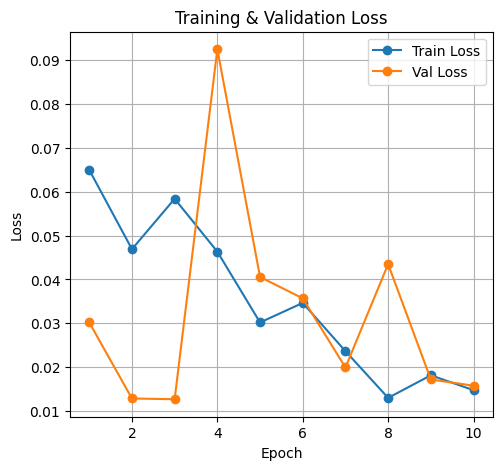

In [38]:
# --- 7️⃣ Plot Metrics ---
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

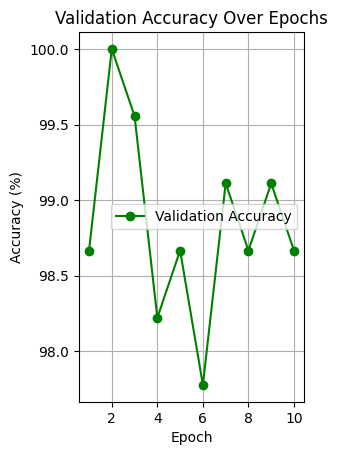

In [39]:

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
def predict_image(img_path, model, transform, classes, device):
    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    img = transform(image).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    # Visualization
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {classes[predicted.item()]} ({confidence.item()*100:.2f}%)", fontsize=14)
    plt.show()

    return classes[predicted.item()], confidence.item()*100

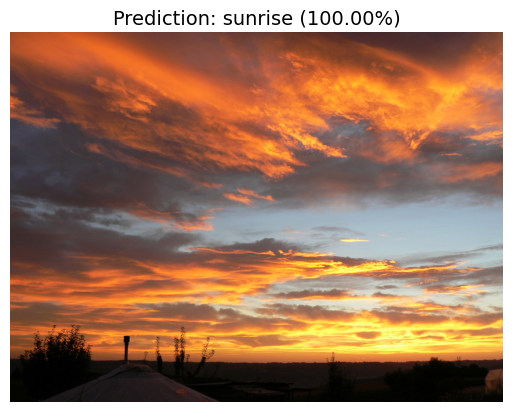

Predicted Weather: sunrise
Confidence: 100.00%


In [41]:
# Suppose your class labels are:
classes = ['cloudy', 'rainy', 'shine', 'sunrise']

# Example call:
img_path = "/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset/Sunrise/sunrise10.jpg"

label, conf = predict_image(img_path, model, transform, classes, device)

print(f"Predicted Weather: {label}")
print(f"Confidence: {conf:.2f}%")

In [42]:
torch.save(model.state_dict(), "weather_classifier.pth")